### Nome: Samuele Pio Lipani

In [19]:
library("tidyverse")
library("plotly")
library("lubridate")

Warning message:
"package 'plotly' was built under R version 4.0.5"

Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:stats':

    filter


The following object is masked from 'package:graphics':

    layout



Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




## Esercizio 1 - Triangular distribution 
La distribuzione triangolare è definita per casi tramite le relazioni:

\begin{equation}
f(X) = \left\{ \begin{array} \ \frac{2(x-a)}{(b-a)(c-a)} \quad a \leq x < c \\ \frac{2(b-x)}{(b-a)(b-c)} \quad c \leq x \leq b \\ 0 \quad \text{altrimenti} \end{array} \right.
\end{equation}

dove $c \in [a,b]$. Si chiede di:
- rappresentare la funzione dato un intervallo $[a,b]$;
- scrivere un algoritmo che estragga numeri randomicamente dalla distribuzione $f$;
- generare $10^4$ punti, rappresentarli in un istogramma insieme alla curva teorica $f(X)$.

#### Grafico della distribuzione di probabilità
Affinchè la distribuzione di probabilità non abbia divergenze bisogna escludere i casi singolari in cui $b=a,c=a,b=c$. 
Inoltre ci rendiamo conto di come tale pdf sia già normalizzata infatti:
$$ \int_a^b f(x) \ \mathrm{dx} = \text{area di un triangolo} = \frac{(b-a)f(c)}{2} $$
Nel caso ad esempio in cui $a=1,c=2,b=3$ si ritrova esattamente che l'area totale sottesa dalla pdf e cioè la probabilità totale nel dominio di definizione della funzione è $1$.

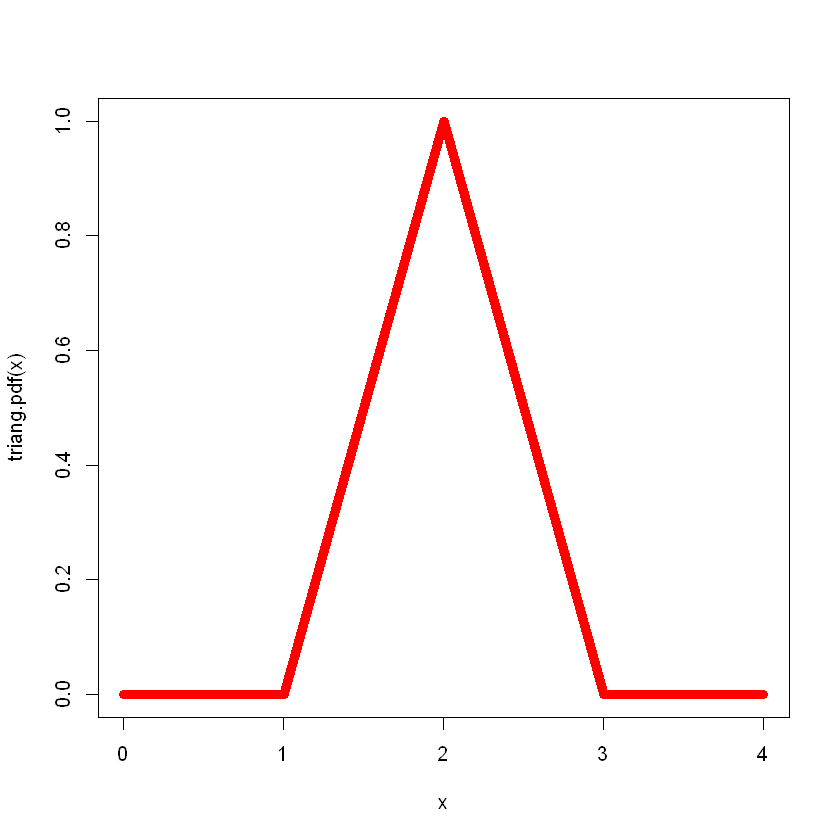

In [5]:
triang.pdf <- function(x,a=1,c=2,b=3) {
    y <- ifelse((x < c & x >= a), 2*(x-a)/((b-a)*(c-a)), ifelse((x >= c & x <= b), 2*(b-x)/((b-a)*(b-c)), 0))    
    return(y)
}

x = seq(0,4,length=10000)

plot(x,triang.pdf(x), col="red")

#### Random sampler 
Utilizzando il metodo dell'inverse sampling calcolo inizialmente la CDF a partire dalla distribuzione di probabilità, ne trovo l'inversa ed estraggo da essa i samples fornendole come input un vettore di probabilità $y$ randomicamente tratte nell'intervallo $[0,1]$.
Sia la CDF calcolata analiticamente:

\begin{equation}
f(X) = \left\{ \begin{array} \ \frac{2(x-a)}{(b-a)(c-a)} \quad a \leq x < c \\ \frac{2(b-x)}{(b-a)(b-c)} \quad c \leq x \leq b \\ 0 \quad \text{altrimenti} \end{array} \right.
\end{equation}

E' possibile mostrare che 

$$ F(x)= \left\{ \begin{array} \ 0 \qquad \qquad \qquad \qquad x \leq a\\ \ \frac{(x-a)^2}{(b-a)(c-a)} \qquad \qquad a \leq x \leq c \\ \ \frac{(b-c)^2-(b-x)^2}{(b-a)(b-c)} + \frac{c-a}{b-a} \ \ c \leq x \leq b \\ \ 1 \qquad \qquad \qquad \qquad x \geq b \end{array} \right. $$

In [6]:
# utilizzo l'espressione analitica della cdf 
triang.cdf <- function(x, lower.tail = TRUE, a=1,c=2,b=3) {
    # innanzitutto controllo che per x <= a la cdf deve essere uguale a zero; quando invece x appartiene al primo intervallo utilizzo 
    # la seconda espressione; non è necessario imporre che per x>=b la cdf sia uno in quanto si riconduce al caso precedente
    y <- ifelse((x <= a), 0, ifelse((x >= b),1,ifelse((x <= c),(x-a)^2/((b-a)*(c-a)),((b-c)^2-(b-x)^2)/((b-a)*(b-c)) + (c-a)/(b-a))))
    if (lower.tail == FALSE) {y <- (1 - y)}
    return(y)
}

# integro numericamente la pdf per verificare che i due metodi coincidano 
triang.cdf.num <- function(x,lower.tail=TRUE,a=1,c=2,b=3) {
    f <- function(x) {ifelse((x < c & x >= a), 2*(x-a)/((b-a)*(c-a)), ifelse((x >= c & x <= b), 2*(b-x)/((b-a)*(b-c)), 0))}
    g <- Vectorize(function(z) {integrate(f, a, z)$value})
    y <- ifelse((x <= a), 0, ifelse((x >= b),1,g(x)))
    if (lower.tail == FALSE) {y <- (1 - y)}
    return(y)
}

#### Plot della cdf function


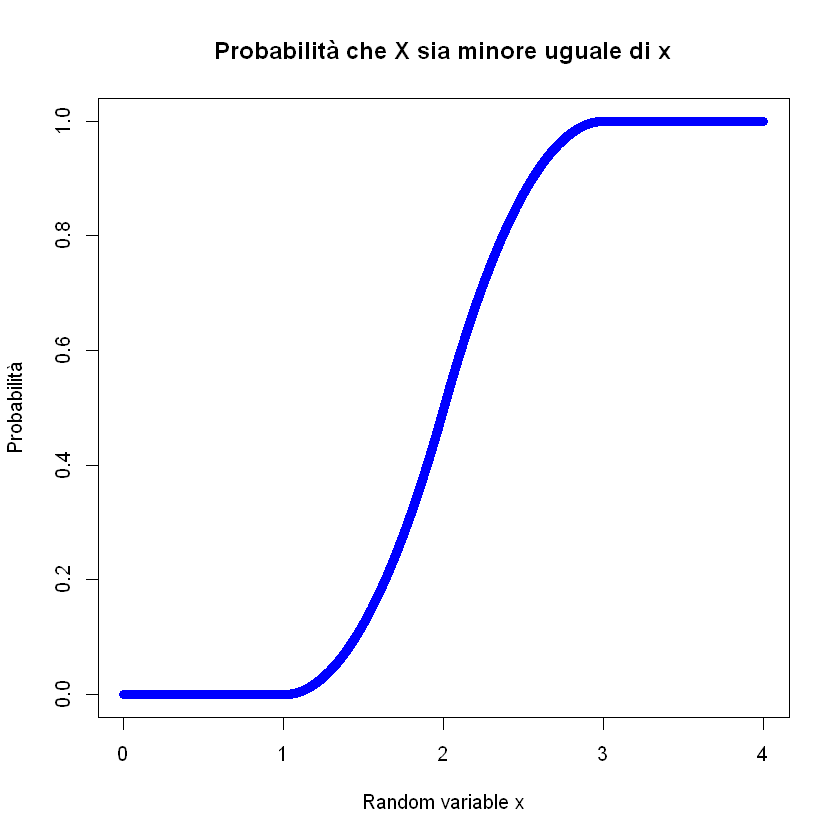

In [7]:
plot(x,triang.cdf(x), main="Probabilità che X sia minore uguale di x", xlab="Random variable x", ylab="Probabilità", col="blue")

Se $X$ è una random variable continua con CDF $F_X$ allora la variabile random $F_X$ ha una distribuzione uniforme in $[0,1]$. Invertendo la $F_X$ e dandole in pasto samples estratti randomicamente in $[0,1]$ il risultato sarebbero samples estratti dalla nostra distribuzione di partenza.

Essendo la distribuzione di probabilità definita per casi è necessario invertire la cdf negli intervalli $[a,c]$ e $[b,c]$.
Utilizzo lo stesso metodo numerico visto nell'homework numero due per invertire la funzione $F(X)$:

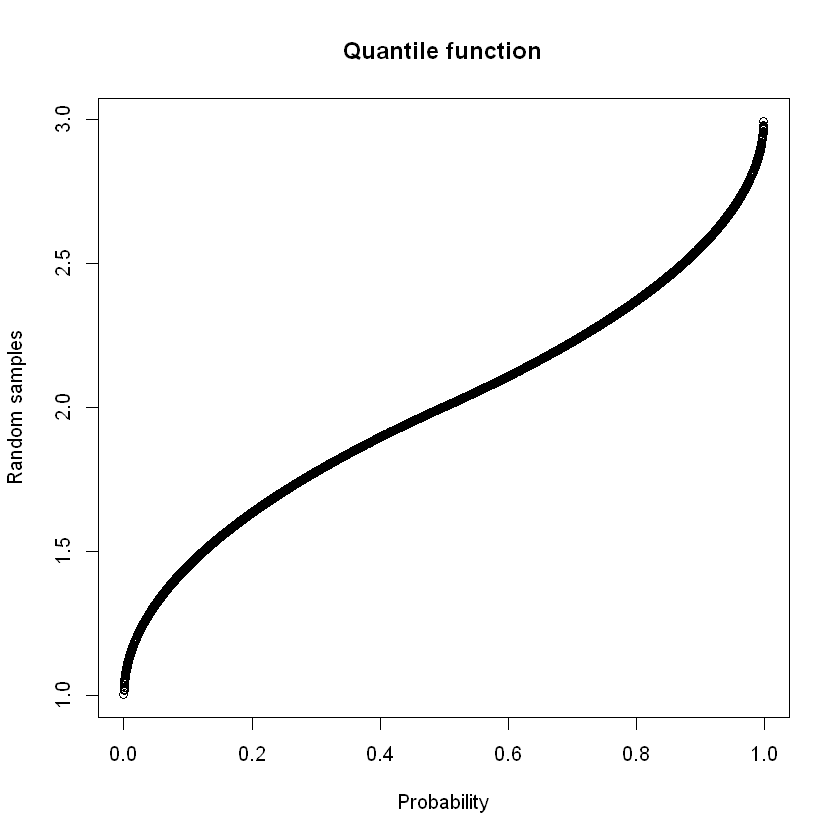

In [8]:
triang.qdf <- function(x) {
    x.out = c()
    y = triang.cdf(x)
    for (i in seq(length(x))){
        y.in = runif(1,min=0,max=1)
        x.out[i] = x[which.min(abs(y-y.in))]
    }
    return(x.out)
}

xres.qdf <- triang.qdf(x)

plot(triang.cdf(xres.qdf),xres.qdf, main="Quantile function",xlab="Probability",ylab="Random samples", col="black")

#### Generazione numeri casuali tramite la qdf
Dopo aver generato $10^4$ numeri casuali rappresento un istogramma con le frequenze di estrazione di tali samples e vi sovrappongo quella che dovrebbe essere la distribuzione di probabilità teorica $f(x)$.

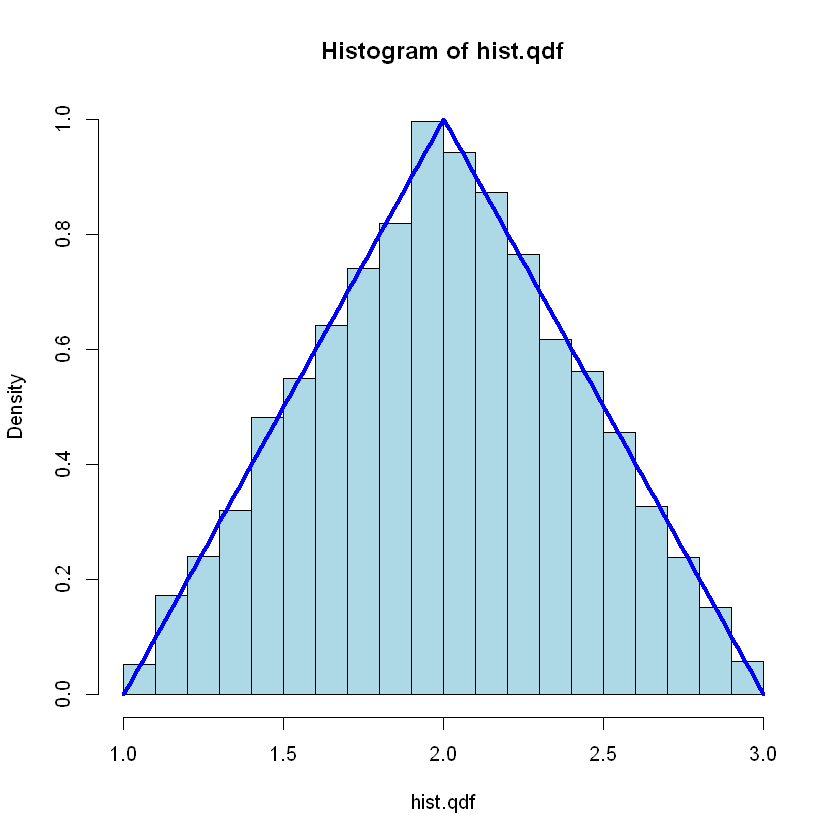

In [9]:
# posso perciò estrarre tramite la qdf 10^4 samples e rappresentare il risultato in un istogramma
xs <- seq(0,4, length=10000)
hist.qdf <- triang.qdf(xs)
hist(hist.qdf, freq=FALSE, col="light blue")
par(lwd = 3.5) 
#quest ultimo comando serve per aumentare lo spessore della curva 
curve(triang.pdf(x), add=T, col="blue")

## Esercizio 2 - Disuguaglianza di Markov
La disuguaglianza di Markov rappresenta un limite superiore per le distribuzioni di probabilità:

$$P(X \geq x) \leq \frac{\mathbb{E}[X]}{k} \ \ \ \ \text{per} \  k>0$$

Avendo definito la funzione $G(k) = 1-F(k) \equiv P(X \geq x)$

Si chiede di rappresentare $G(k)$ e il limite superiore di Markov per le seguenti distribuzioni di probabilità:
- Esponenziale, Exp($\lambda=1$);
- Uniforme, U(3,5);
- Binomiale, Bin($n=1,p=1/2$);
- Poisson, Pois($\lambda=1/2$).
Per fare ciò definiamo quattro funzioni che corrispondono alle quattro cdf con il parametro lower.tail=FALSE e gli altri argomenti fissati per costruzione. 
Utilizzerò inoltre dei funzionali per applicare più facilmente la funzione plot alle quattro cdf ciascuna nel proprio dominio di definzione.

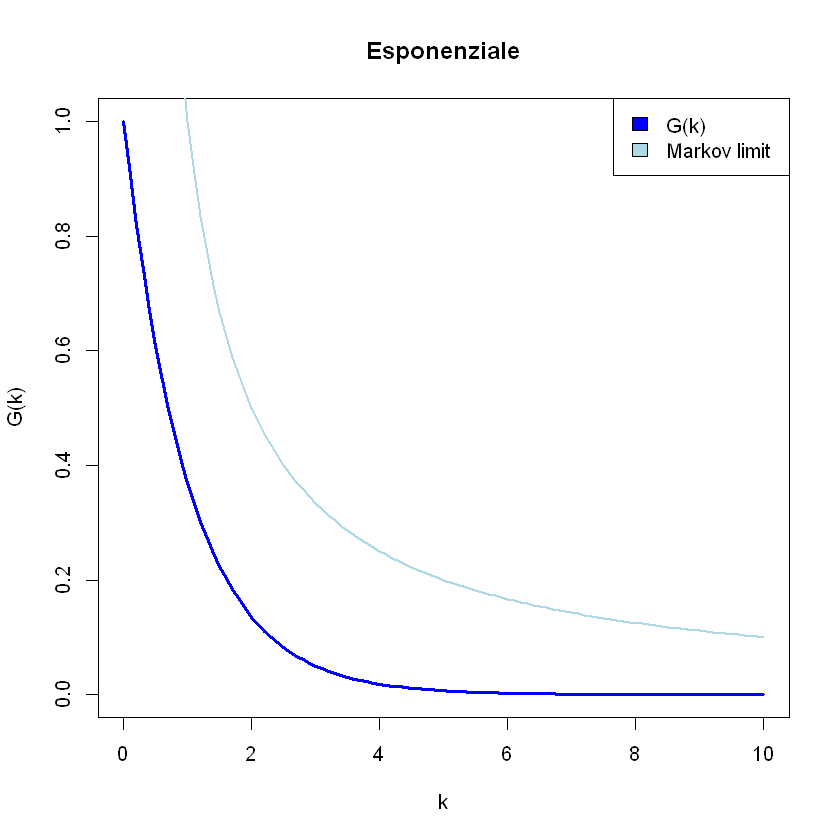

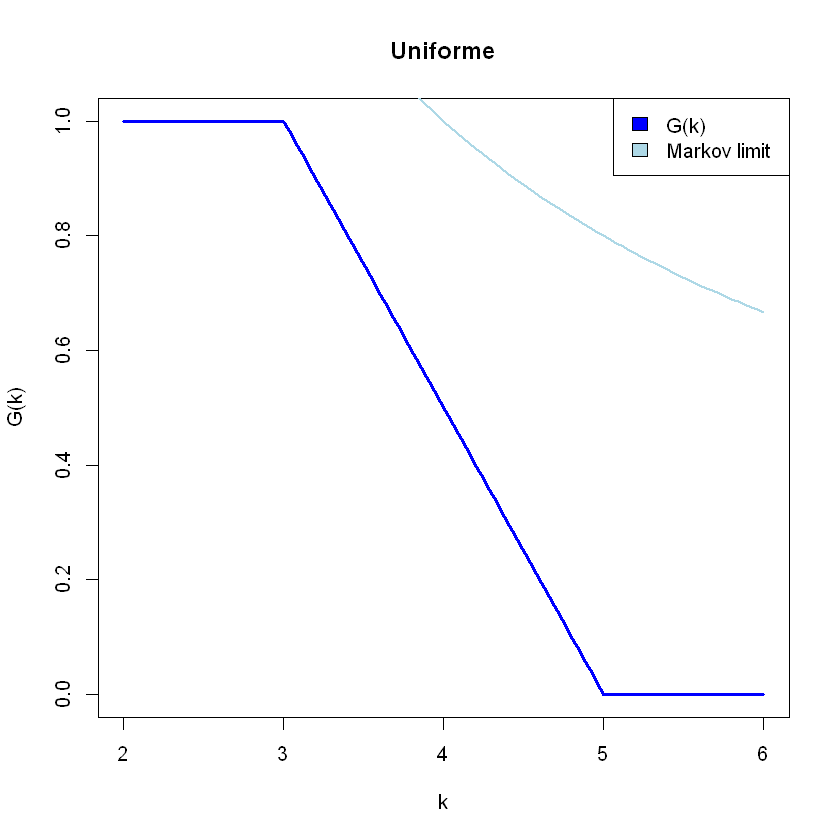

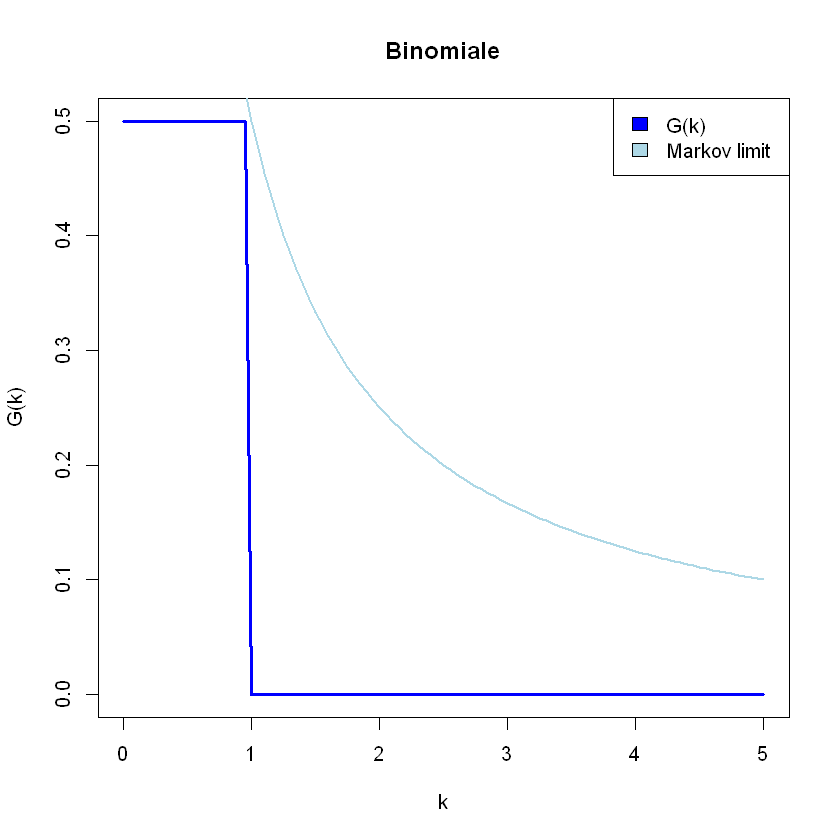

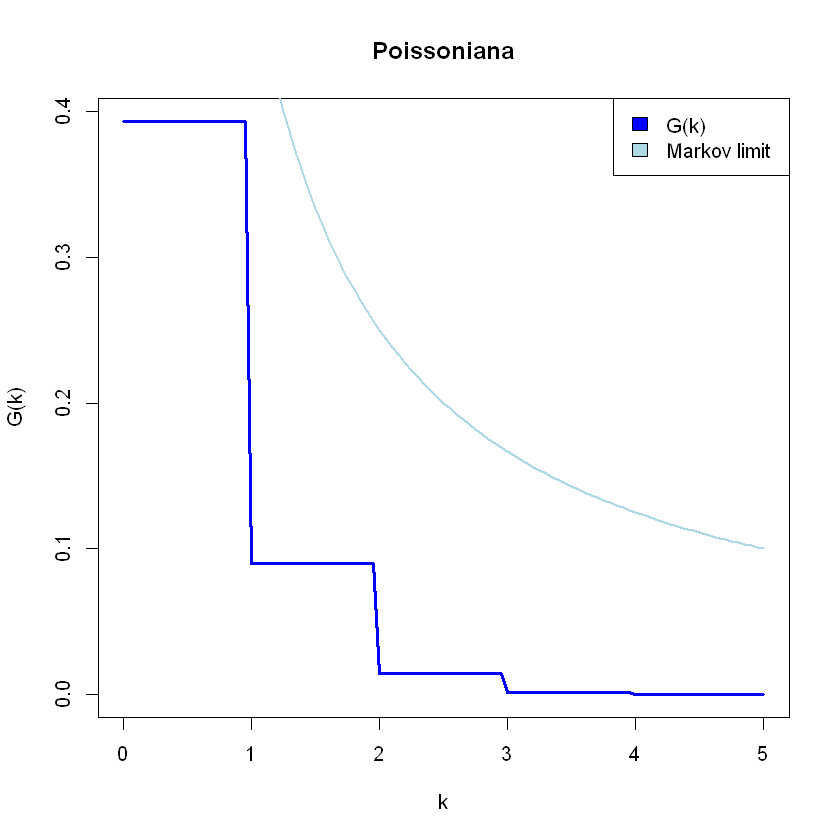

In [10]:
# definisco innanzitutto le quattro cdf 
G.exp <- function(x,lambda=1) pexp(x,rate=lambda,lower.tail = FALSE)
G.unif <- function(x,min=3,max=5) punif(x,min=min,max=max,lower.tail = FALSE)
G.binom <- function(x,size=1,prob=0.5) pbinom(x, size = size, prob = prob, lower.tail = FALSE)
G.pois <- function(x,lambda=0.5) ppois(x, lambda = lambda, lower.tail = FALSE)

#curve(G.exp(x),a,b)
#curve(1/x,add=T)
# devo ripetere quest operazione per tutte e quattro le funzioni quindi anzichè usare un ciclo for utilizzo purr::pmap che mappa una funzione 
# su una lista di altrettante funzioni quindi lavora come un funzionale
# per lavorare con pmap è necessario definire una serie di liste 

G.list <- list(G.exp,G.unif,G.binom,G.pois)
G.names <- list("Esponenziale","Uniforme","Binomiale","Poissoniana")
G.bounds <- list(list(0,10),list(2,6),list(0,5),list(0,5))
G.means <- list(1,4,0.5,0.5)

markov.plot <- function(g,g.name,g.bound,g.mean) {
    min <- g.bound[[1]]
    max <- g.bound[[2]]
    curve(g(x),min,max,lwd=3,col="blue",main=g.name,xlab = "k", ylab = "G(k)")
    curve(g.mean/x,add=T,lwd=2,col="light blue")
    legend("topright",c("G(k)","Markov limit"),fill=c("blue","light blue"))
}

a <- pmap(list(G.list,G.names,G.bounds,G.means),markov.plot)

## Esercizio 3 - Disuguaglianza di Chebyshev
La disuguaglianza di Chebyshev determina un limite superiore alla probabilità che una random variable si possa trovare fuori dall'intervallo $[\mu - k\sigma,\mu + k\sigma]$ dove $\mu$ è il valore di aspettazione, $\sigma$ la deviazione standard e $k$ un numero reale positivo:

$$P(|X-\mu| \geq k\sigma) \leq \frac{1}{k^2} \ \ \ \text{con} \ k>0$$

Mostrare che tale limite vale per le seguenti distribuzioni di probabilità:
- Normale, N($\mu=3,\sigma=5$);
- Esponenziale, Exp($\lambda=1$);
- Uniforme, U($1-\sqrt{2},1+\sqrt{2}$);
- Poisson, Pois($\lambda=1/3$).

Per semplicità anzichè pensare la disuguaglianza come un limite superiore la traduco in un limite inferiore per la probabilità una random variable appartenga all'intervallo $[\mu - k\sigma,\mu + k\sigma]$:

$$ P(|X-\mu| \geq k\sigma) = 1 - P(|X-\mu| < k\sigma) \\ 1 - P(|X-\mu| < k\sigma) \leq \frac{1}{k^2} \longrightarrow P(|X-\mu| < k\sigma) \geq 1 - \frac{1}{k^2} $$

e la probabilità che $x \in [\mu - k\sigma,\mu + k\sigma]$ si può tradurre tramite la cumulative distribution function $F(X)$ in 

$$ P(|X-\mu| < k\sigma) = F(\mu+k\sigma) - F(\mu-k\sigma) $$

Per rappresentare la disuguaglianza di Chebyshev sfruttiamo pertanto la cdf delle distribuzioni di probabilità sopra elencate.

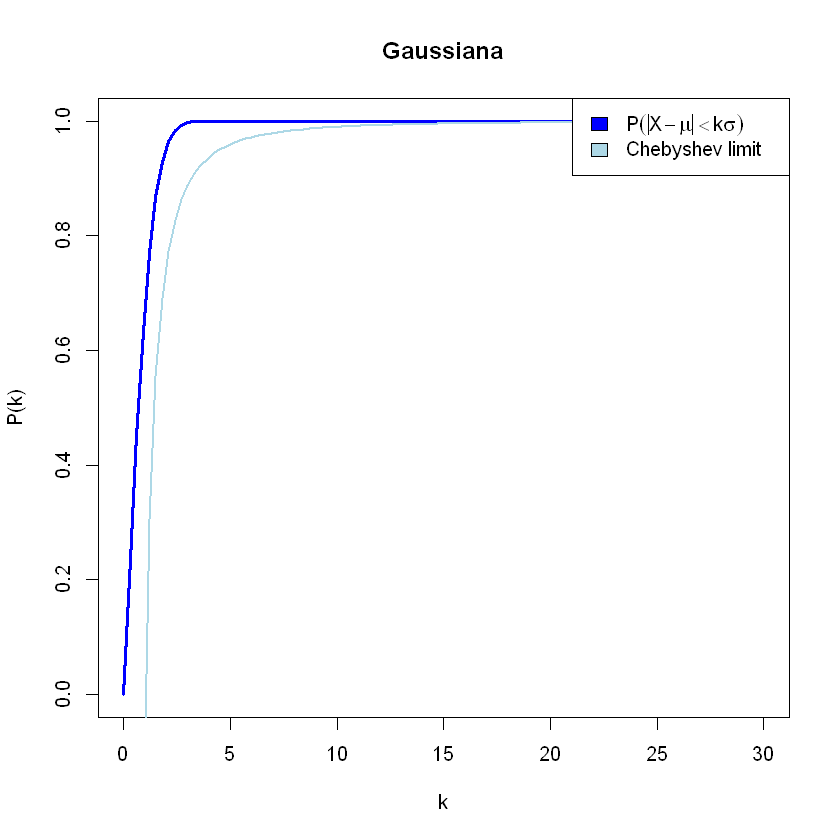

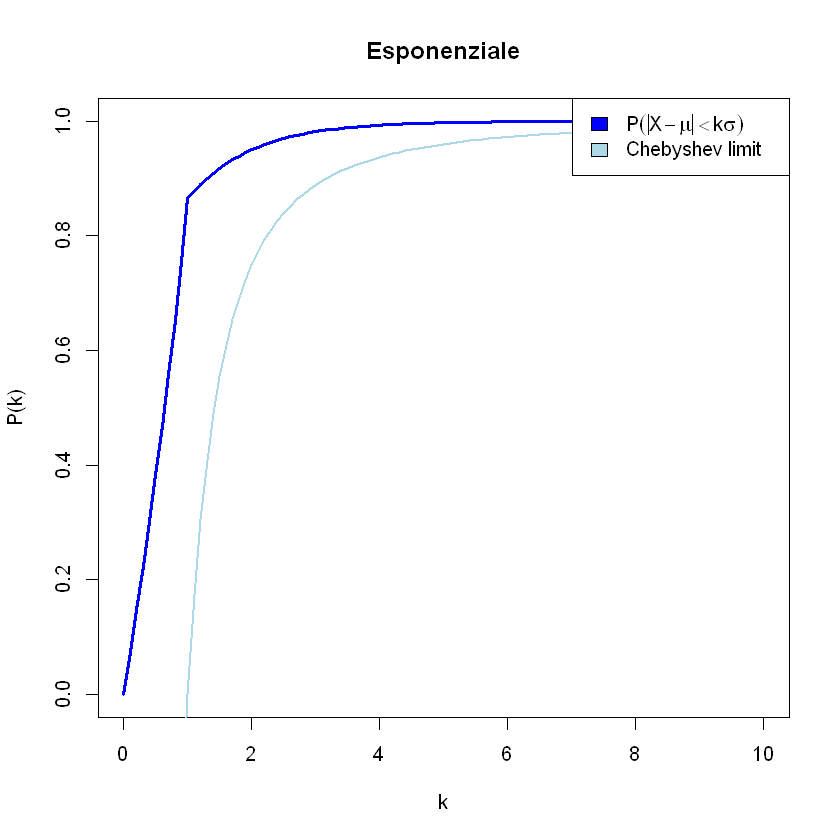

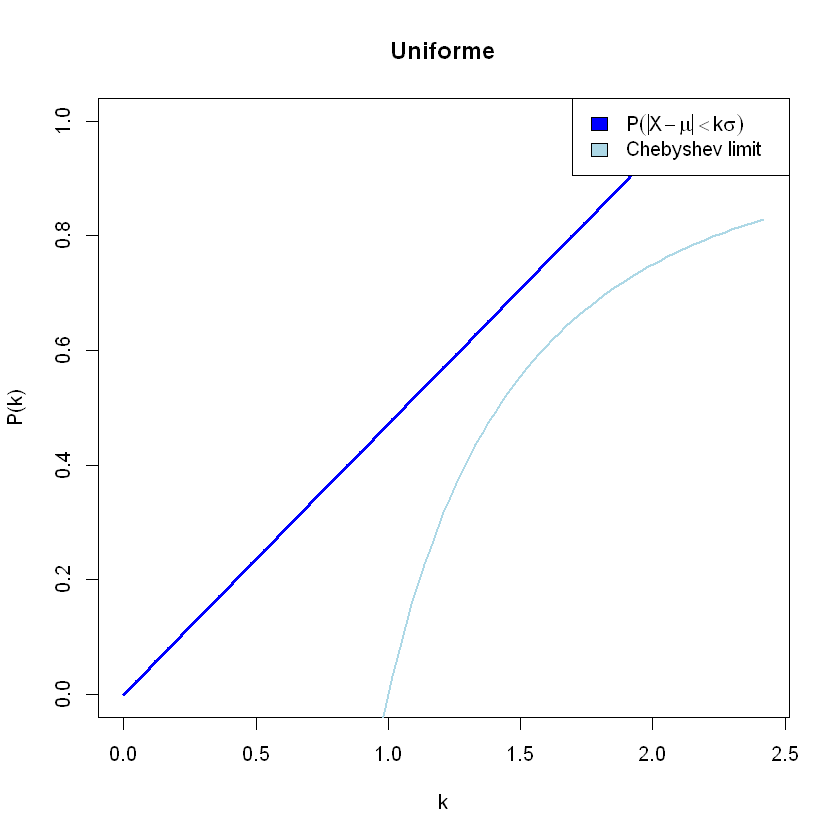

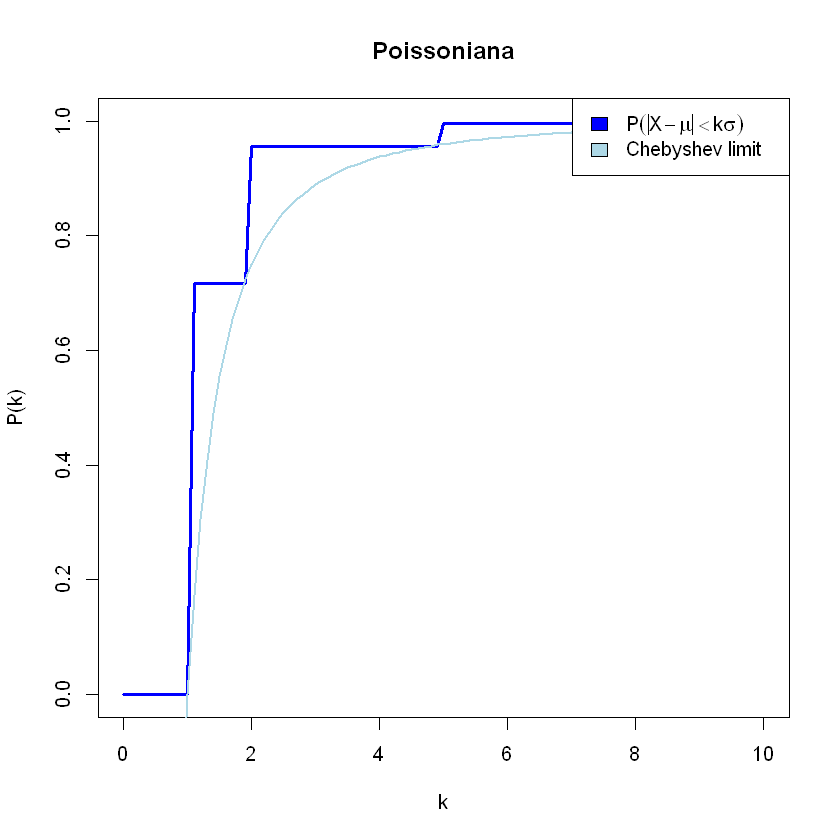

In [11]:
# il procedimento è analogo a quanto visto nell'esercizio precedente, questa volta mantengo TRUE il parametro lower.tail in quanto mi interessa
# il valore di F e non di 1-F 

G.norm <- function(x,mu=3,sigma=5) pnorm(x,mean=mu,sd=sigma)
G.exp <- function(x,lambda=1) pexp(x,rate=lambda)
G.unif <- function(x,min=1-2^0.5,max=1+2^0.5) punif(x,min=min,max=max)
G.pois <- function(x,lambda=1/3) ppois(x, lambda = lambda)

G.list <- list(G.norm,G.exp,G.unif,G.pois)
G.names <- list("Gaussiana","Esponenziale","Uniforme","Poissoniana")
G.bounds <- list(list(0, 30),list(0,10),list(0, 2.42),list(0, 10))
G.means <- list(3,1,1,1/3)
G.std <- list(5,1,2/3,1/3)


markov.plot <- function(g,g.name,g.bound,g.mean,g.std) {
    min <- g.bound[[1]]
    max <- g.bound[[2]]
    curve(g(x*g.std+g.mean)-g(-x*g.std+g.mean),min,max,lwd=3,col="blue",main=g.name,xlab = "k", ylab = "P(k)")
    curve(1-(1/x^2),add=T,lwd=2,col="light blue")
    legend("topright",c(expression(P(abs(X-mu) < k*sigma)),"Chebyshev limit"),fill=c("blue","light blue"))
}

a <- pmap(list(G.list,G.names,G.bounds,G.means,G.std),markov.plot)

## Esercizio 4 - Community Mobility Open Data


In [22]:
url <- "https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv"
df <- read_csv(url) # a tibble
head(df)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  country_region_code = col_character(),
  country_region = col_character(),
  sub_region_1 = col_character(),
  sub_region_2 = col_logical(),
  metro_area = col_logical(),
  iso_3166_2_code = col_character(),
  census_fips_code = col_logical(),
  place_id = col_character(),
  date = col_date(format = ""),
  retail_and_recreation_percent_change_from_baseline = col_double(),
  grocery_and_pharmacy_percent_change_from_baseline = col_double(),
  parks_percent_change_from_baseline = col_double(),
  transit_stations_percent_change_from_baseline = col_double(),
  workplaces_percent_change_from_baseline = col_double(),
  residential_percent_change_from_baseline = col_double()
)


Warning message:
"5455848 parsing failures.
 row        col           expected                  actual                                                                  file
3900 metro_area 1

country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<lgl>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AE,United Arab Emirates,NA,NA,NA,NA,NA,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0,4,5,0,2,1
AE,United Arab Emirates,NA,NA,NA,NA,NA,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1,4,4,1,2,1
AE,United Arab Emirates,NA,NA,NA,NA,NA,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-17,-1,1,5,1,2,1
AE,United Arab Emirates,NA,NA,NA,NA,NA,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-18,-2,1,5,0,2,1
AE,United Arab Emirates,NA,NA,NA,NA,NA,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-19,-2,0,4,-1,2,1
AE,United Arab Emirates,NA,NA,NA,NA,NA,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-20,-2,1,6,1,1,1


In [24]:
df.ita <- filter(df, country_region == "Italy")
head(df.ita)

country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<lgl>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IT,Italy,NA,NA,NA,NA,NA,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-15,3,-1,35,9,0,-1
IT,Italy,NA,NA,NA,NA,NA,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-16,3,2,26,11,1,-2
IT,Italy,NA,NA,NA,NA,NA,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-17,0,1,7,3,1,0
IT,Italy,NA,NA,NA,NA,NA,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-18,3,1,16,4,1,0
IT,Italy,NA,NA,NA,NA,NA,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-19,0,-1,11,3,1,0
IT,Italy,NA,NA,NA,NA,NA,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-20,2,1,18,5,1,0


In [25]:
# rimuoviamo i dati corrispondenti alle singole regioni quindi manteniamo soltanto le righe in cui sub_region1 == NA 
df.ita.national <- df.ita[is.na(df.ita$sub_region_1),]
head(df.ita.national)

country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<lgl>,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IT,Italy,NA,NA,NA,NA,NA,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-15,3,-1,35,9,0,-1
IT,Italy,NA,NA,NA,NA,NA,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-16,3,2,26,11,1,-2
IT,Italy,NA,NA,NA,NA,NA,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-17,0,1,7,3,1,0
IT,Italy,NA,NA,NA,NA,NA,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-18,3,1,16,4,1,0
IT,Italy,NA,NA,NA,NA,NA,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-19,0,-1,11,3,1,0
IT,Italy,NA,NA,NA,NA,NA,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-20,2,1,18,5,1,0


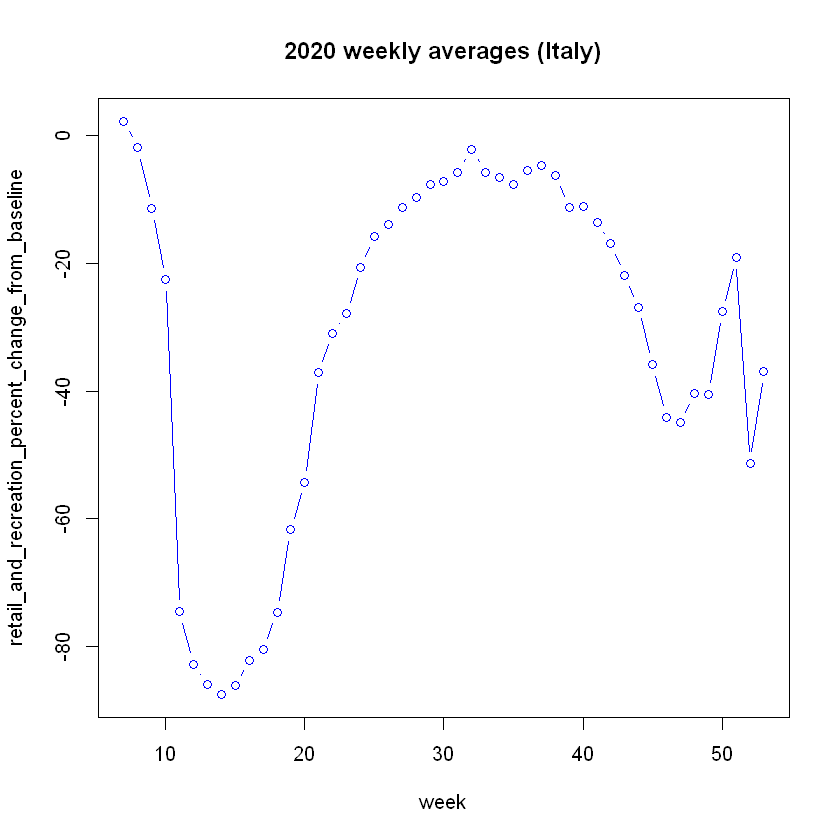

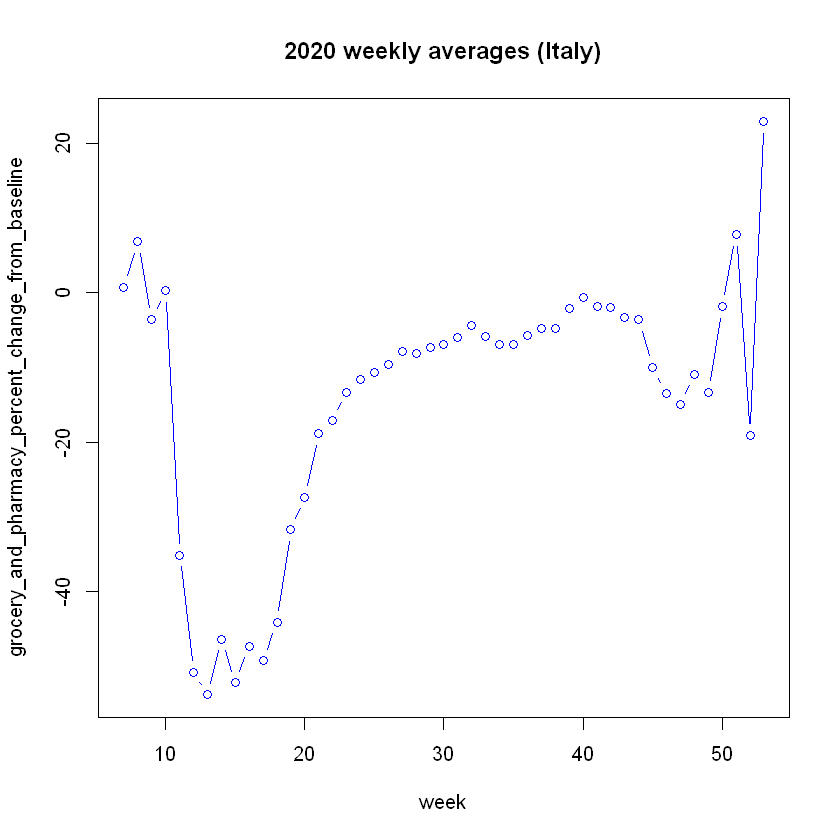

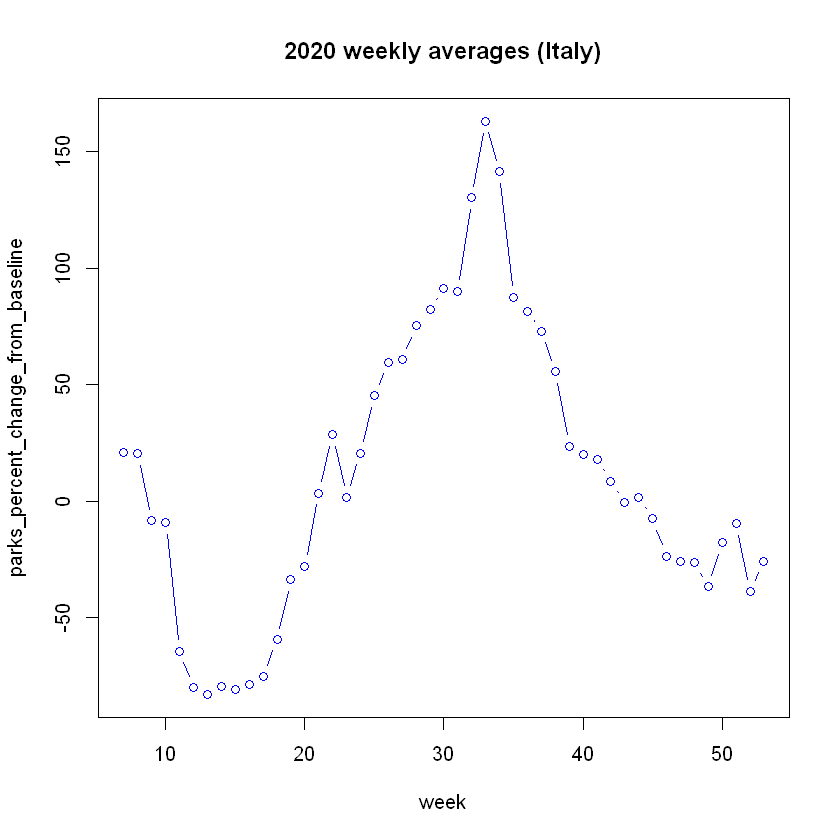

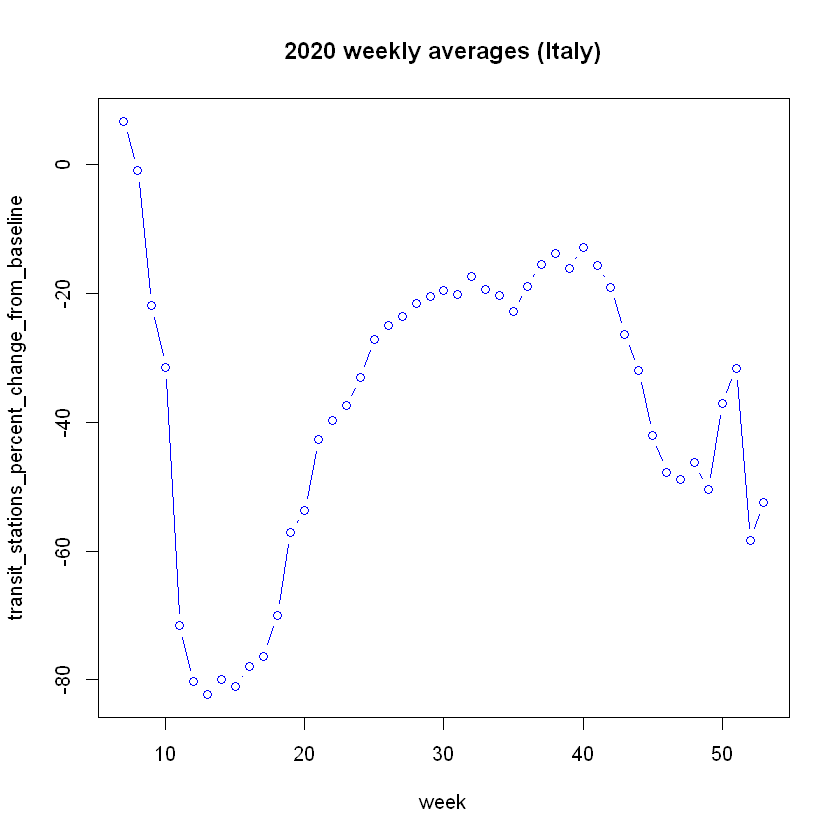

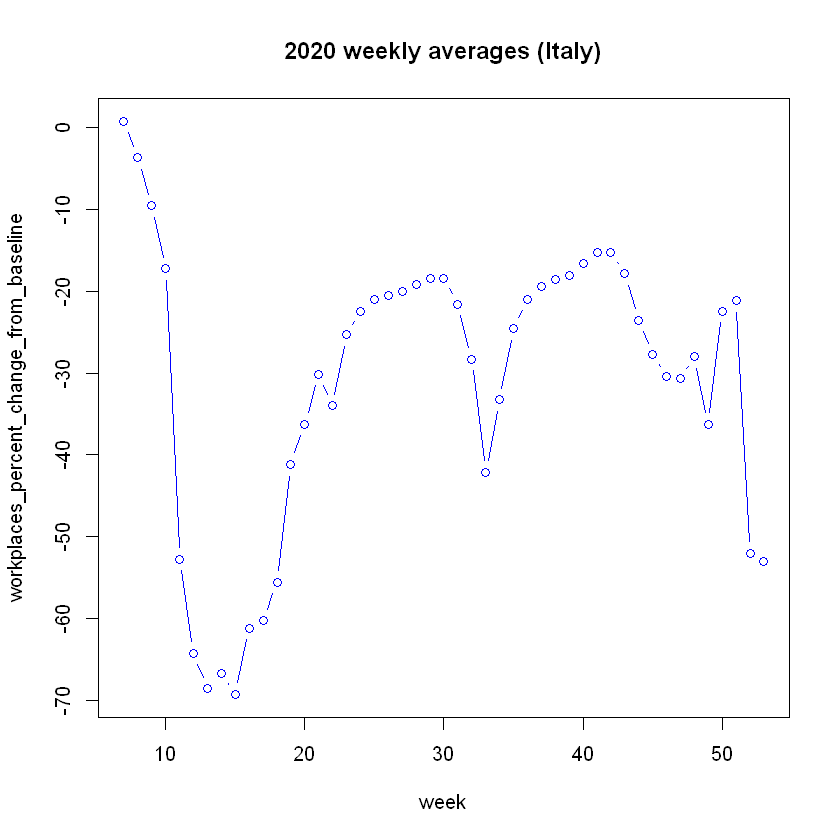

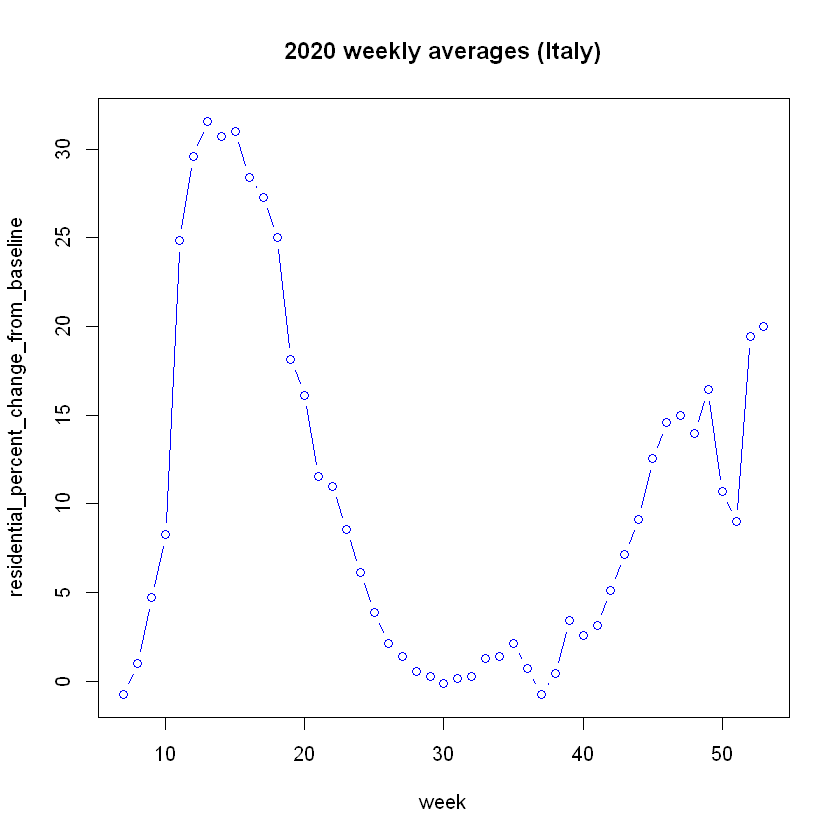

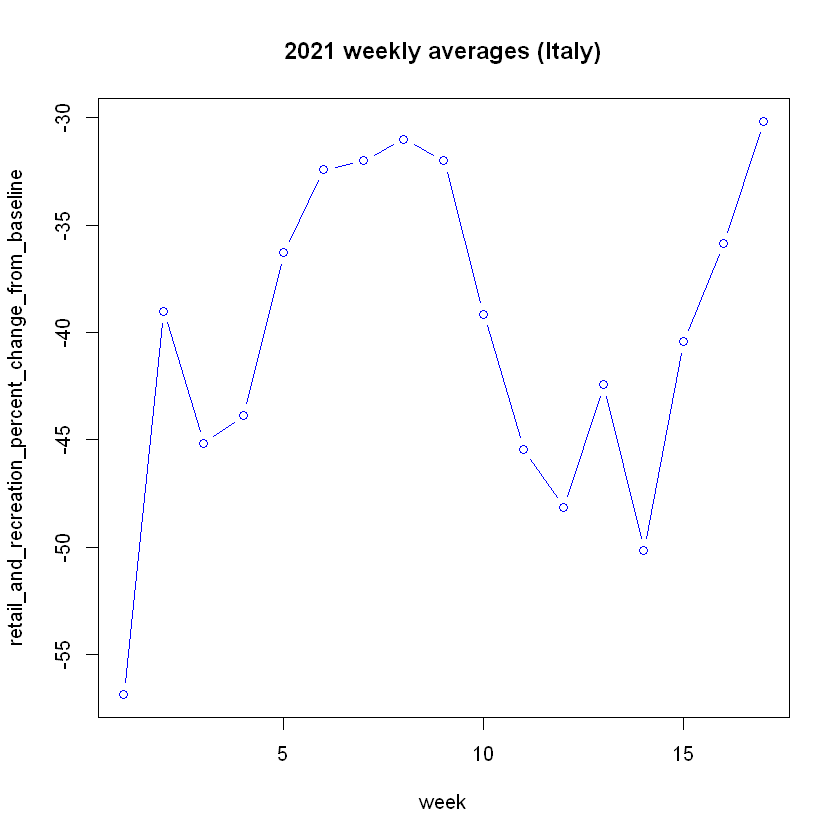

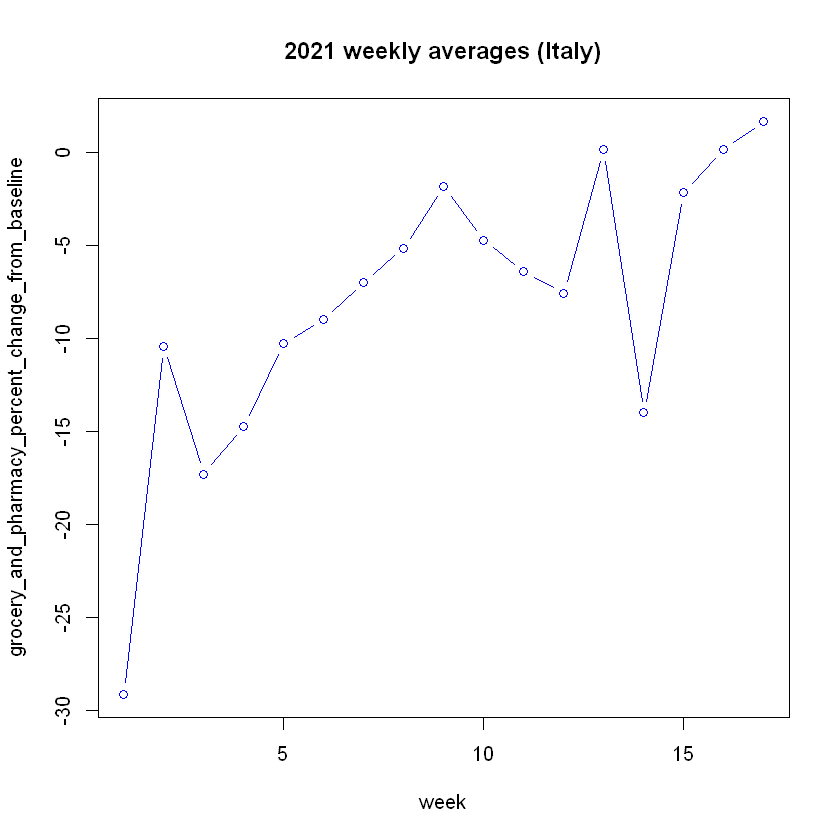

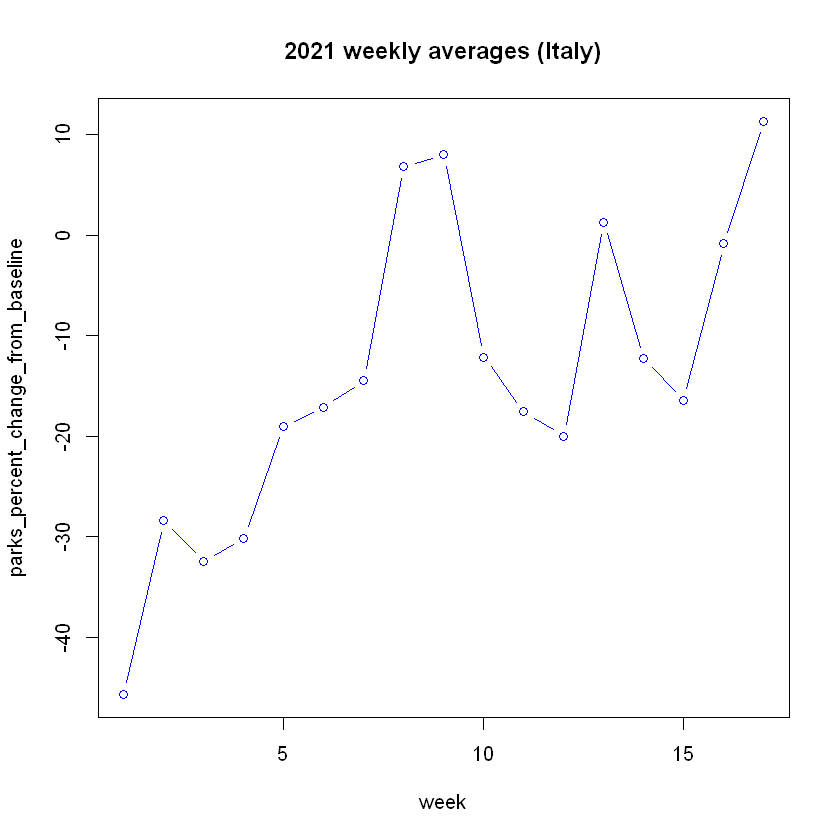

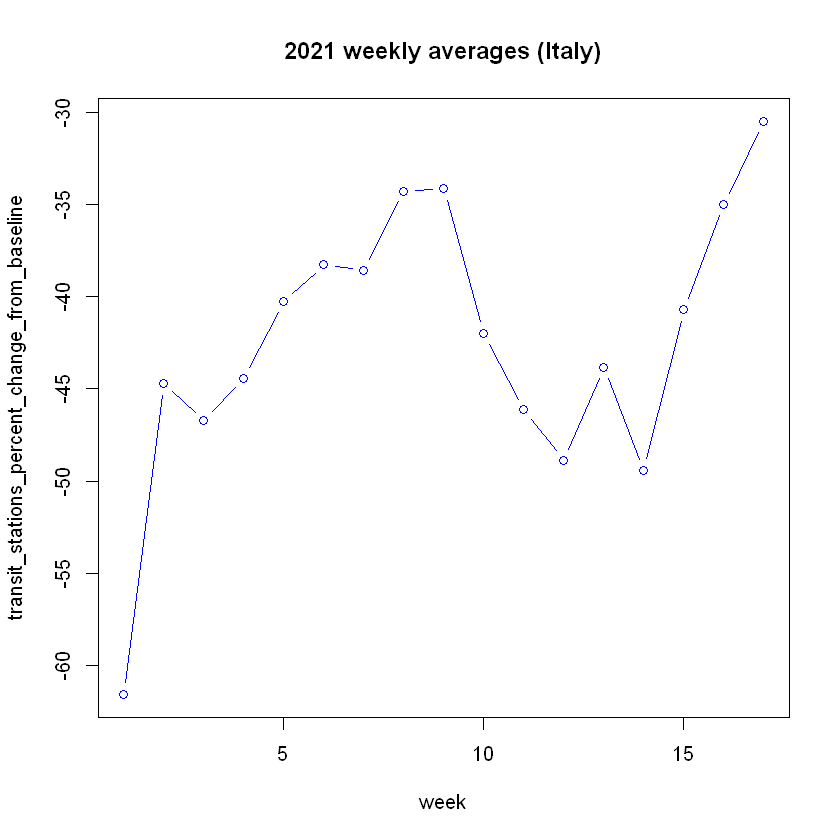

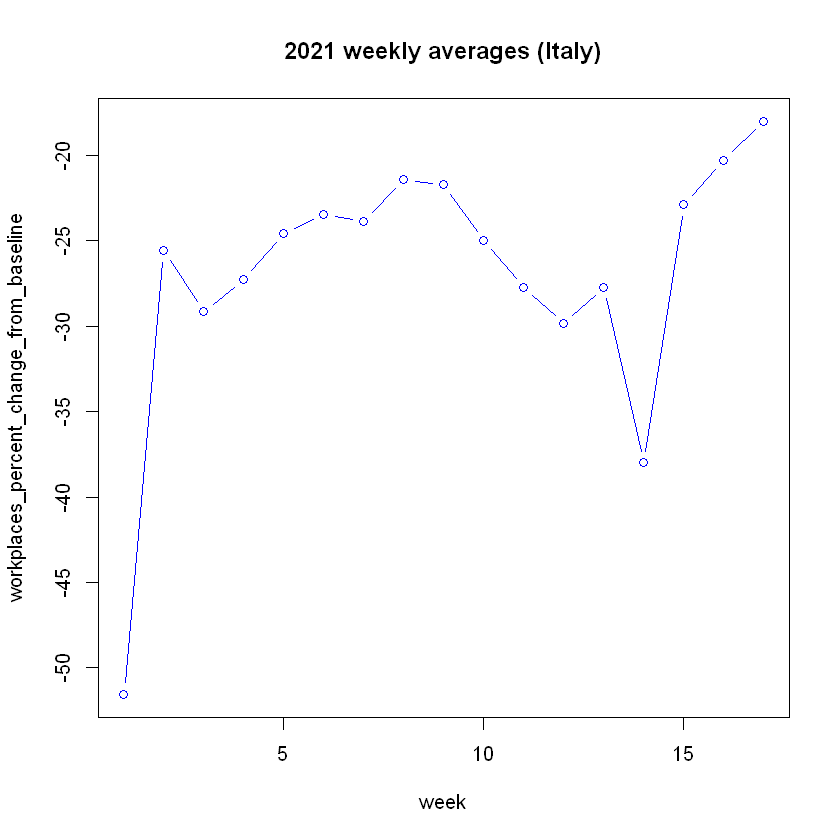

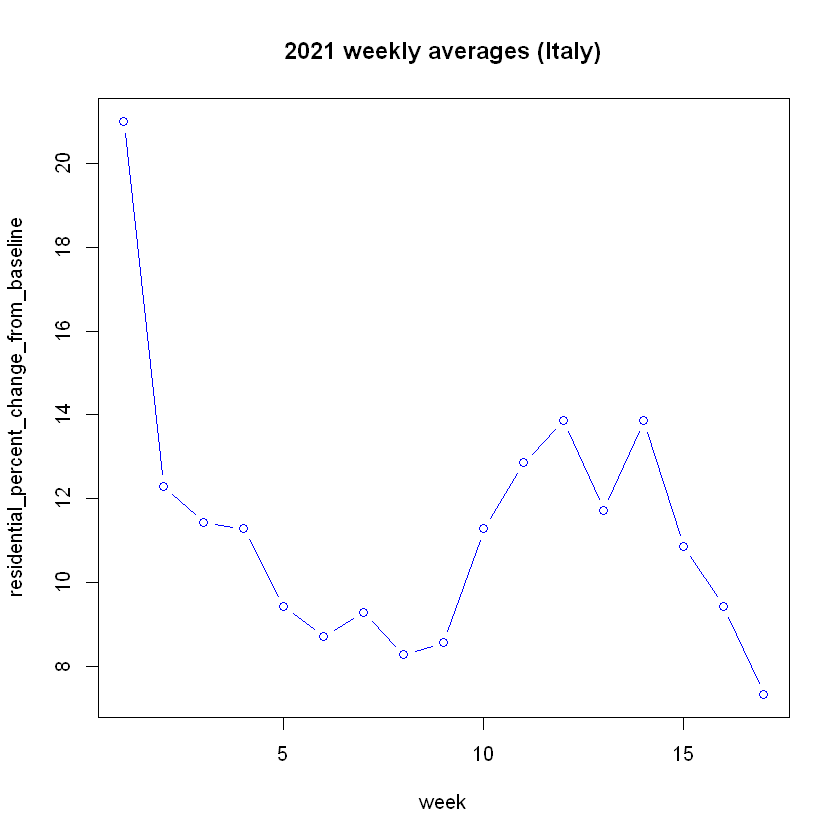

In [20]:
date.to.week <- function(df, year) {
    year.mask <- as.numeric(format(df$date, format = "%Y")) == year
    df1 <- df[year.mask,]
    df1$date <- week(df1$date) 
    names(df1)[9] <- "week" 
    return(df1)
}

df.ita.2020 <- date.to.week(df.ita.national, year = 2020)
df.ita.2021 <- date.to.week(df.ita.national, year = 2021)



average.over.weeks.plot <- function(df, year, country) {
    
    numeric.columns.names <- names(df)[10:15]
    
    for (col in numeric.columns.names) {
        df[col] %>% aggregate(by = list(df$week), FUN = mean) -> df1  
        plot(df1, xlab = "week", type = "b", col = "blue", main = sprintf("%d weekly averages (%s)", year, country))
    }
}

average.over.weeks.plot(df.ita.2020, 2020, "Italy")
average.over.weeks.plot(df.ita.2021, 2021, "Italy")

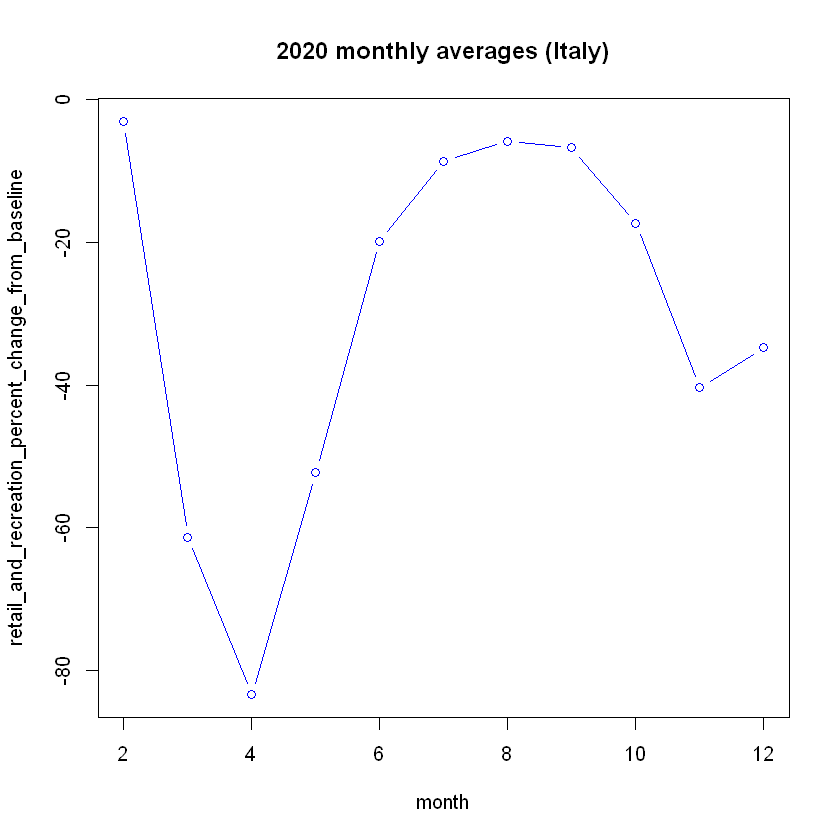

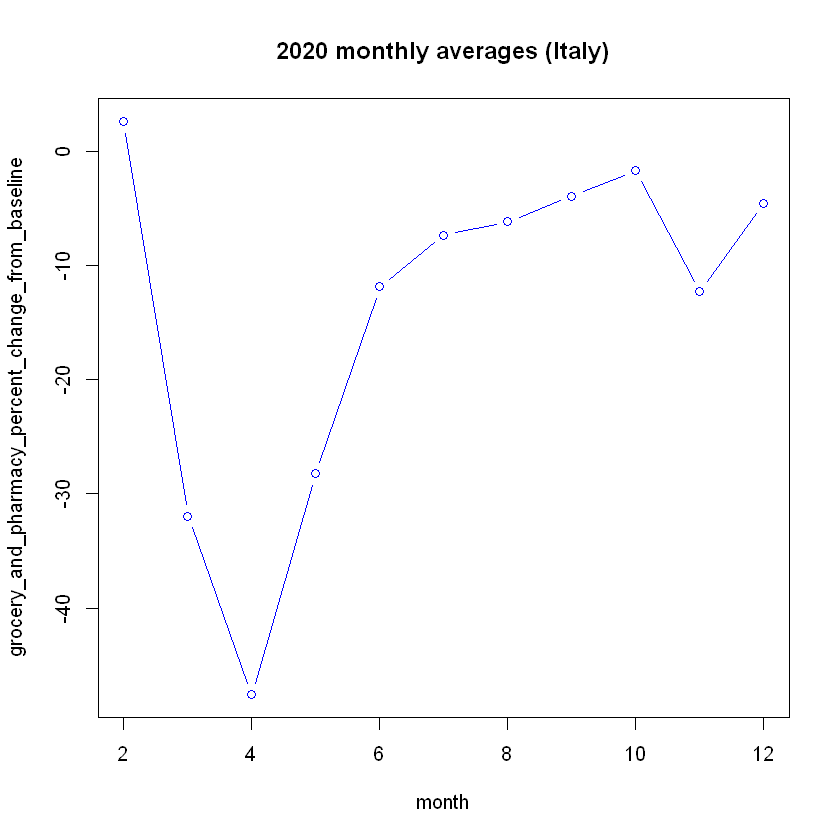

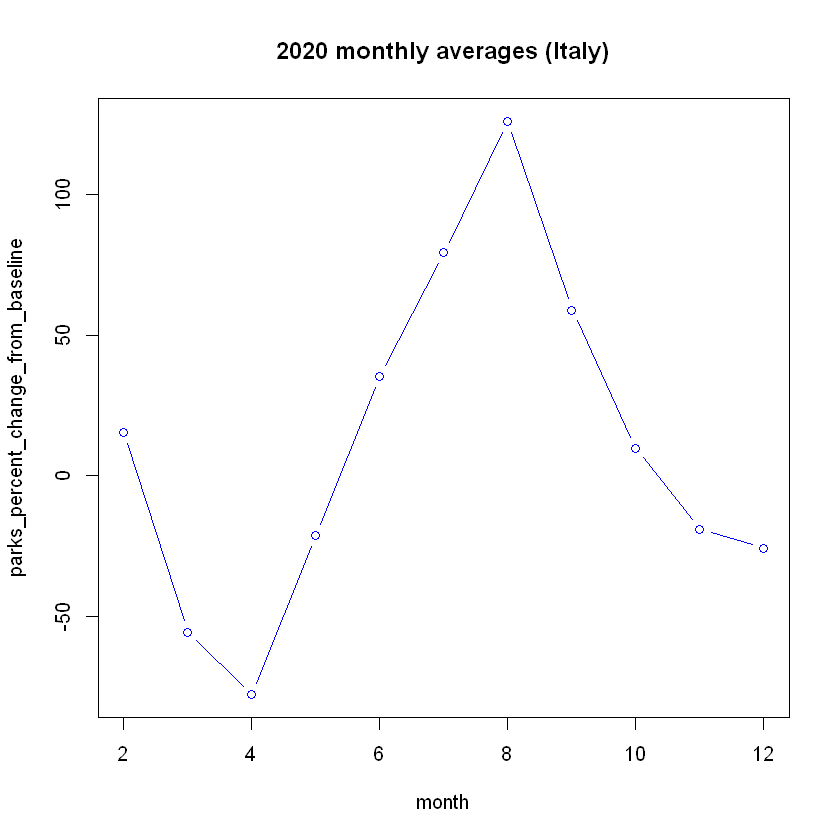

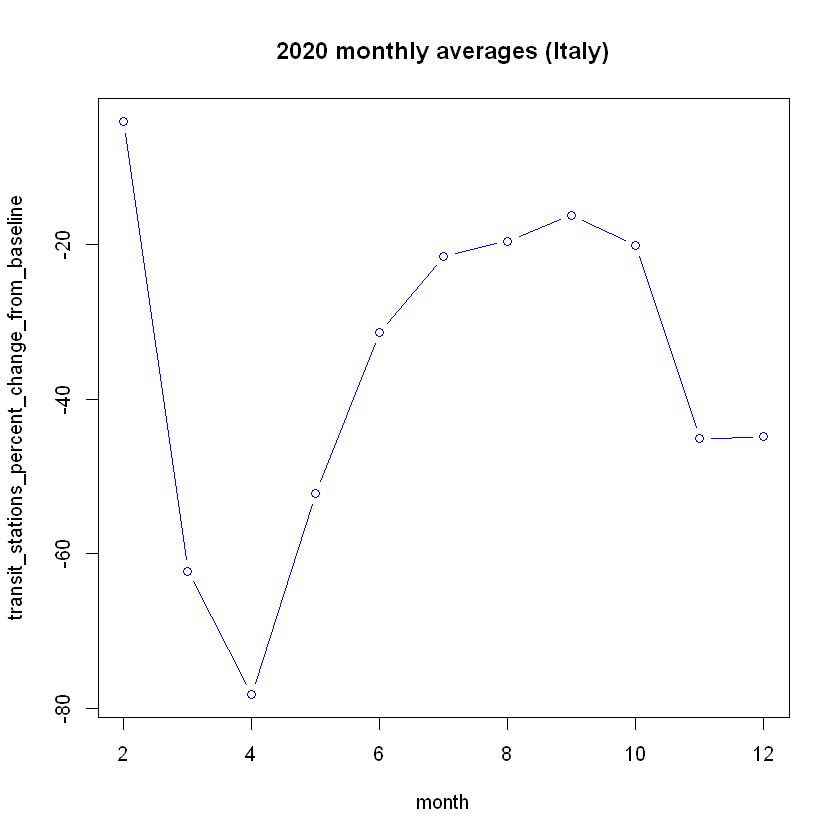

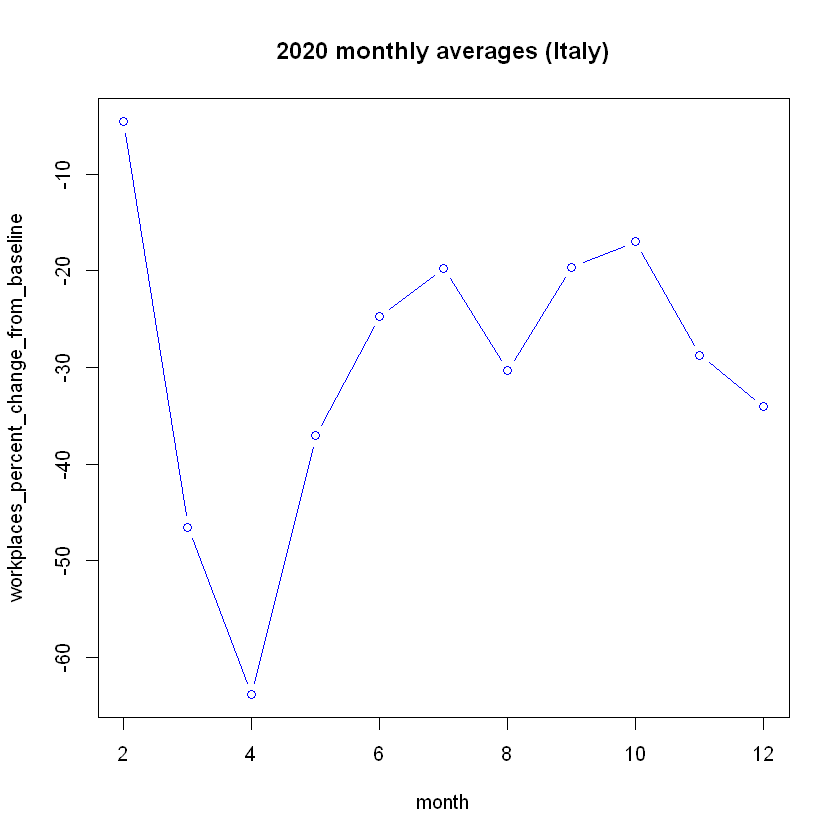

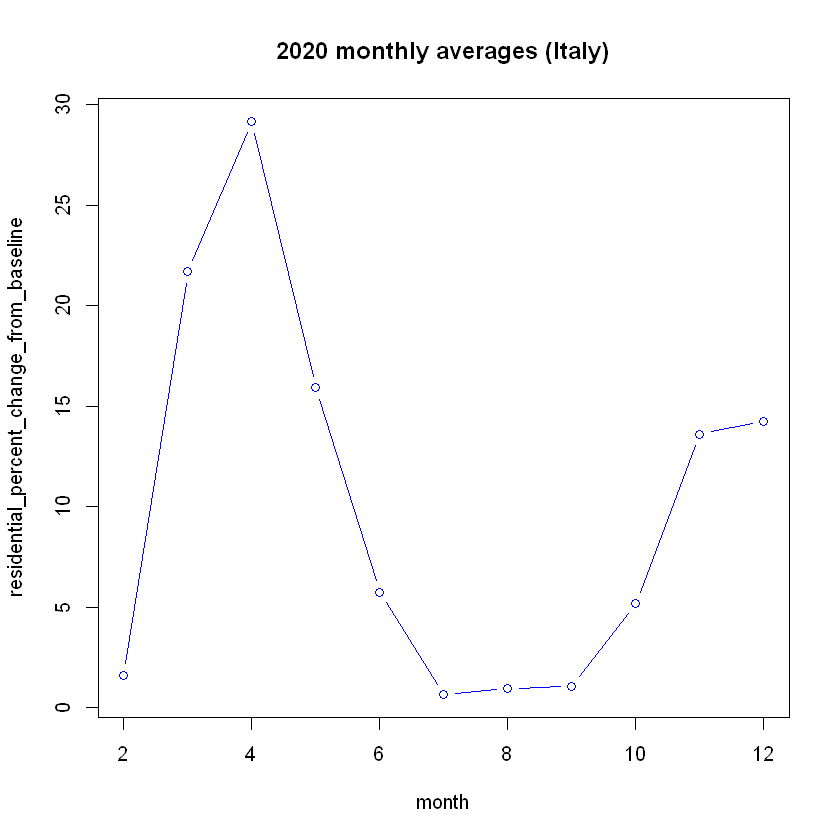

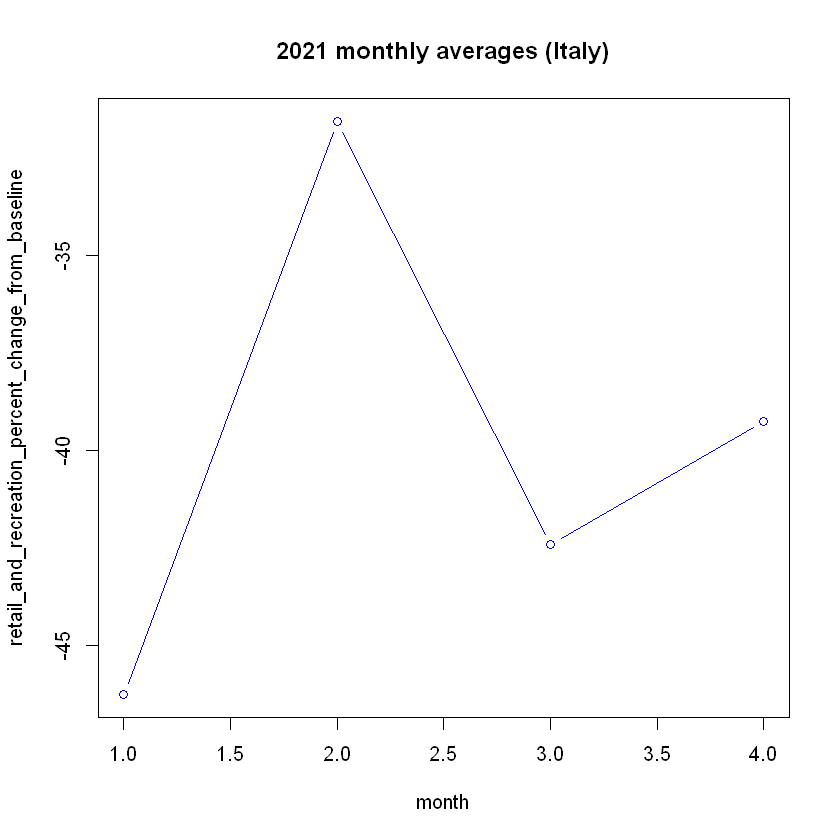

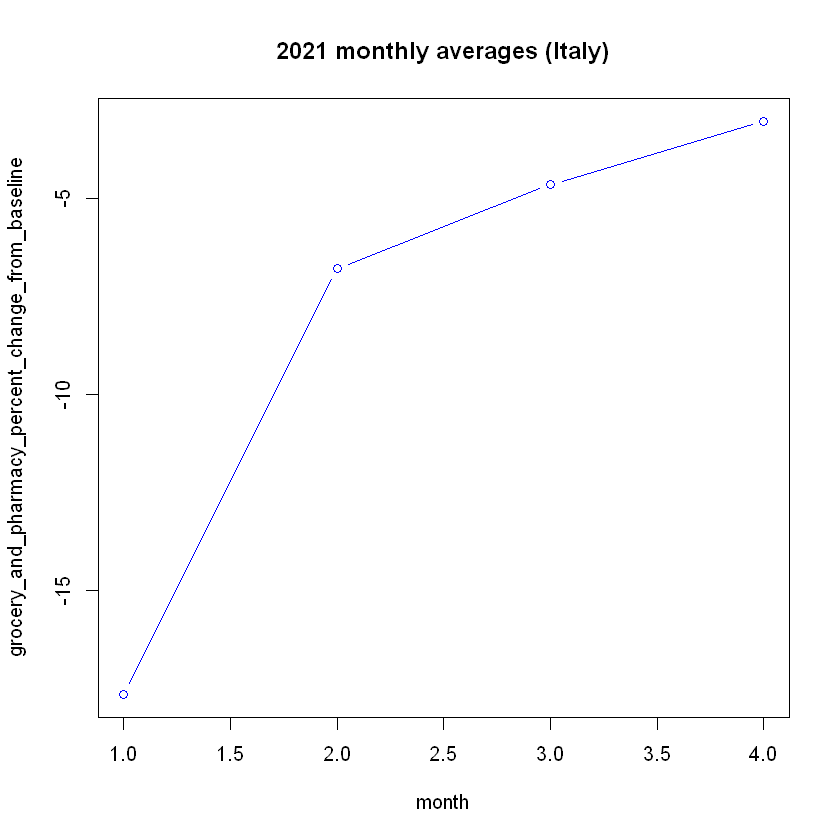

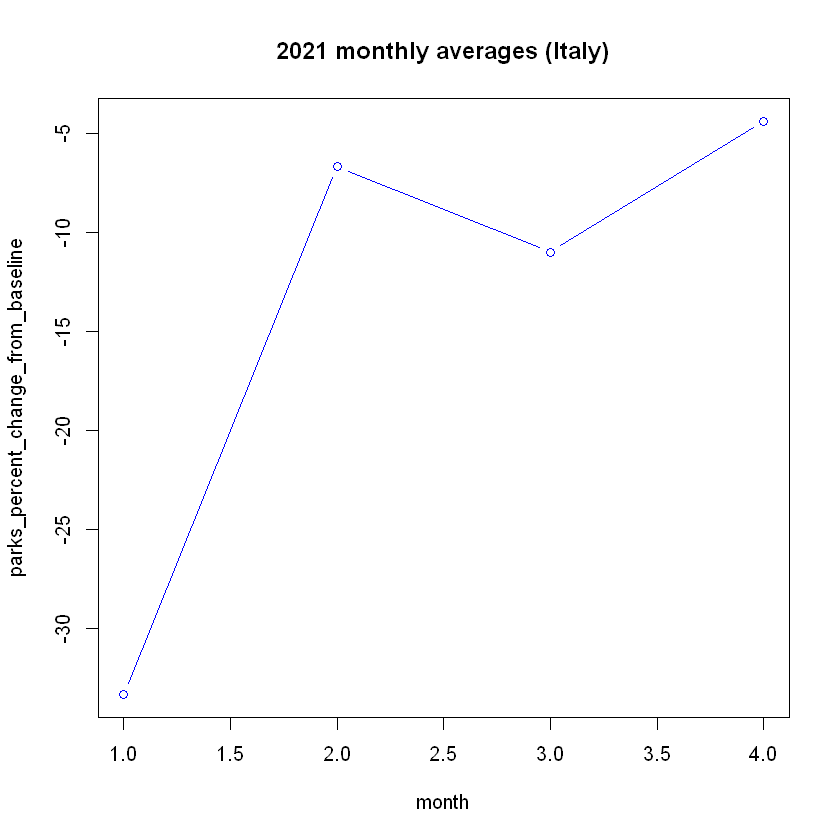

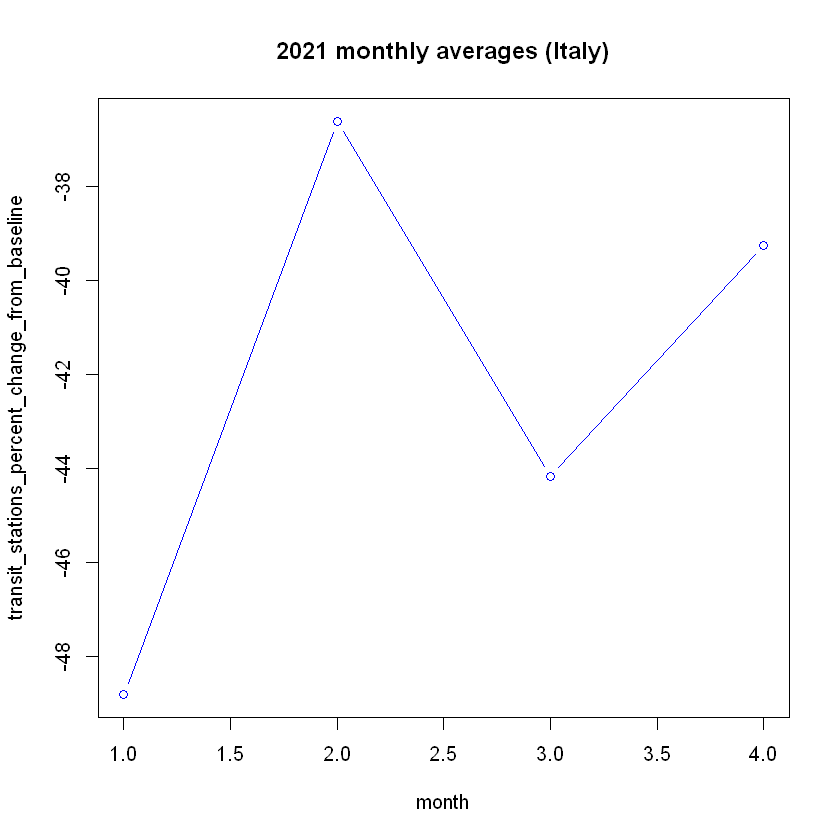

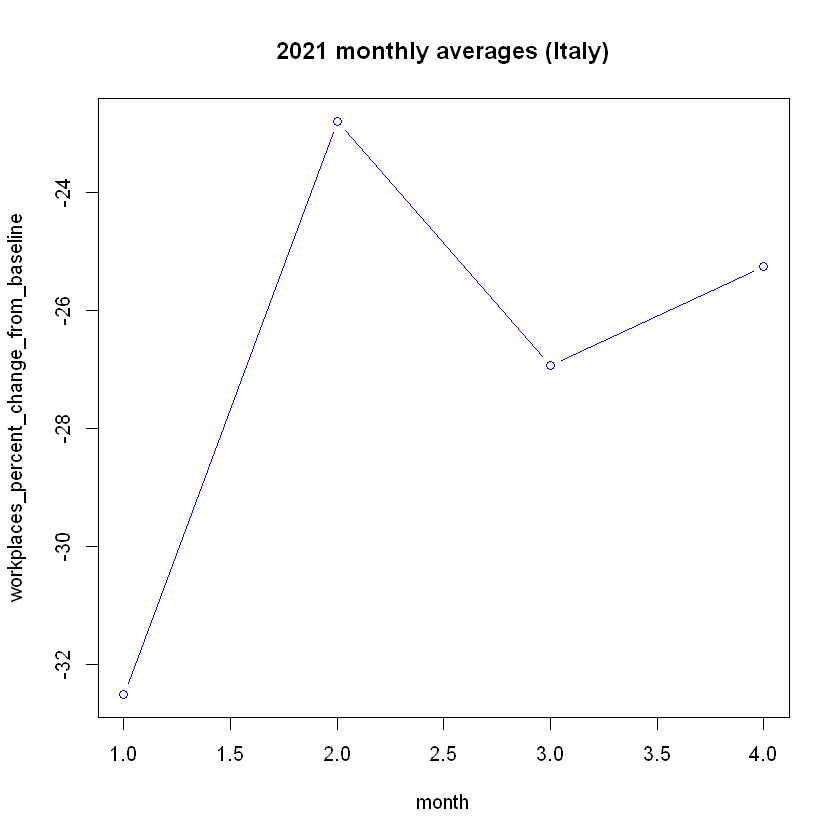

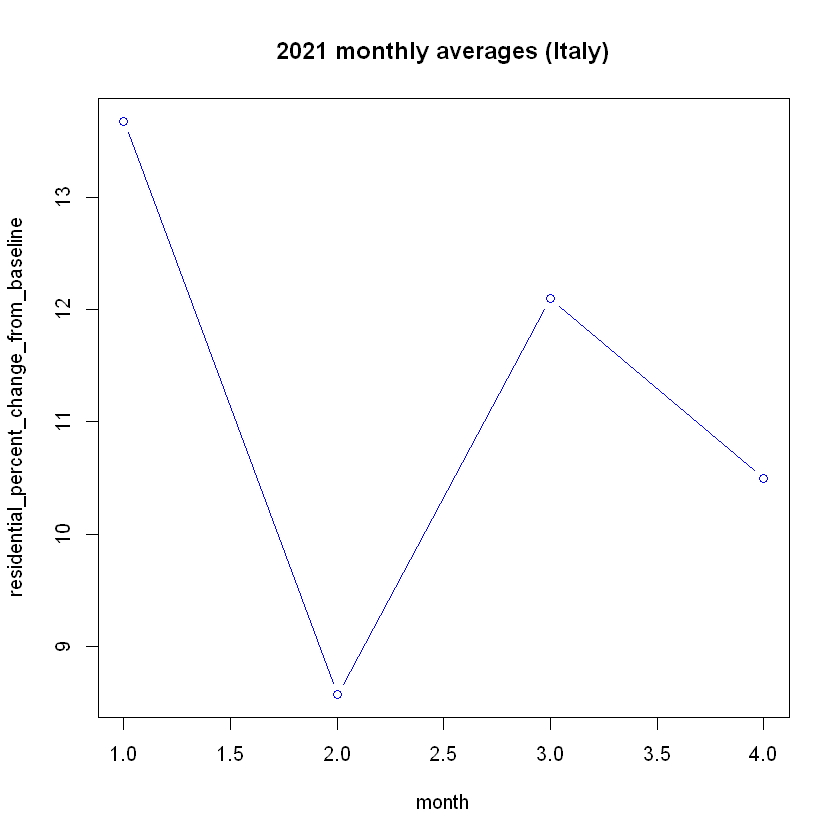

In [21]:
date.to.month <- function(df, year) {
    year.mask <- as.numeric(format(df$date, format = "%Y")) == year
    df1 <- df[year.mask,]
    
    df1$date <- month(df1$date) 
    names(df1)[9] <- "month" 
    return(df1)
}

df.ita.2020 <- date.to.month(df.ita.national, year = 2020)
df.ita.2021 <- date.to.month(df.ita.national, year = 2021)


average.over.months.plot <- function(df, year, country) {
    
    numeric.columns.names <- names(df)[10:15]
    
    for (col in numeric.columns.names) {
        df[col] %>% aggregate(by = list(df$month), FUN = mean) -> df1  
        plot(df1, xlab = "month", type = "b", col = "blue", main = sprintf("%d monthly averages (%s)", year, country))
    }
}

average.over.months.plot(df.ita.2020, 2020, "Italy")
average.over.months.plot(df.ita.2021, 2021, "Italy")